# Import libraries

In [45]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

from helpers import parse_variables, get_risk_level, map_to_color, simulate_quant_trait
from models import ols_regression, manhattan_linear, gc
from deep_learning_models import abyss, deep_abyss

from scipy.stats import t
from scipy import stats
from scipy.stats import entropy

from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from tensorflow.keras import Input, Model, layers, regularizers
from tensorflow.keras.layers import Input, Dense


In [46]:
# Names of the environmental risks
naming_dict = {
    "no_risk": "no environmental risk",
    "NW_risk": "Smooth linear North-West environmental risk",
    "N_risk" : "Smooth linear North environmental risk",
    "blob_risk": "Localised big blob risk",
    "center_risk": "Localised big central risk",
    "big_square_risk": "big square risk",
    "square_risk" : "Tiny square risk",
    'hi_square_risk' : "Tiny square risk",
    "hi_gauss_blob_risk": "Global Gaussian Risk",
    "two_square_risk": "Two tiny risks",
    "gauss_blob_risk" : "Gaussian Risk",
    "three_square_risk": "Three localized Risks",
    "mid_mid_square_risk": "Mid square risk"
}

# Load genotype

In [47]:
dict = parse_variables('geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
k = int(dict['k'])
M = float(dict['M'])

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

number_of_snps = (G*L)/2 # one loci per chromosome
number_of_individuals = c*k*k

In [48]:
very_rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [49]:
very_rare = very_rare.rename(columns=lambda x: 'VR' + x)/2
#very_rare = very_rare.iloc[::-1].reset_index(drop=True)
rare = rare.rename(columns=lambda x: 'R' + x)/2
common = common.rename(columns=lambda x: 'C' + x)/2
complete = pd.concat([common, rare, very_rare], axis=1)
complete = ((complete*2)-1)

# load population

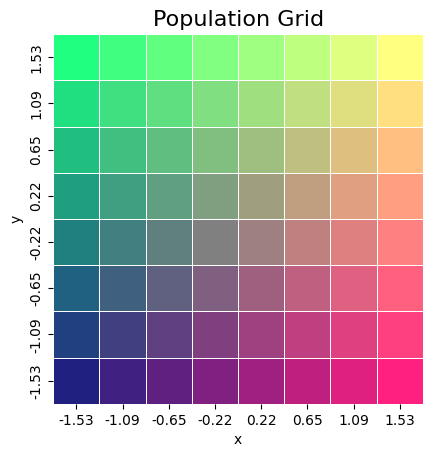

In [50]:
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")
populations['population_number'] = populations['populations'].str.extract('(\d+)').astype(int)
# Calculating X and Y coordinates
populations['x'] = ((populations['population_number'] - 1) % k) + 1
populations['y'] = ((populations['population_number'] - 1) // k) + 1
populations['z'] = 0.5
populations['population'] = populations['population_number']/(k*k)
palette = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]

# Standardize the vector
std_dev = np.std(populations['x'])
mean = np.mean(populations['x'])
populations['x'] = np.round((populations['x'] - mean) / std_dev,2)

std_dev = np.std(populations['y'])
mean = np.mean(populations['y'])
populations['y'] = np.round((populations['y'] - mean) / std_dev,2)

# Check the grid
df_agg = populations.groupby(['x', 'y']).agg({'population': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='population')


heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()

# Load environmental risk

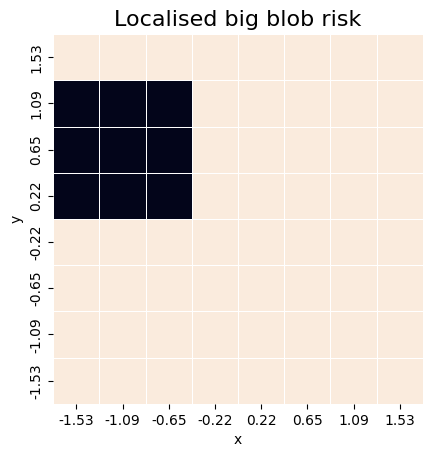

In [51]:
risk_level = get_risk_level()
risk_level = risk_level.split("\n")[-1]
name_risk = risk_level.split('_fun')[0]
risk = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/environmental_risks/risk_{name_risk}.pkl")
populations[name_risk] = risk[name_risk]
df_agg = populations.groupby(['x', 'y']).agg({name_risk: 'mean'}).reset_index()
grid_df = df_agg.pivot(index='y', columns='x', values=name_risk)
sns.heatmap(grid_df, cmap='rocket_r', linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title(f"{naming_dict[name_risk]}", fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()

# Find true allele frequency per population block (by counting)

In [52]:
"""
complete['pop'] = populations['population_number']

p2s_dfs = []
q2s_dfs = []
twopqs_dfs = []
for pop in list(populations['population_number'].unique()):
    snps = []
    p2s = []
    twopqs = []
    q2s = []
    temp = complete[complete['pop'] == pop]
    temp.drop("pop", axis=1, inplace=True)
    for snp in list(temp.columns):
        try:
            num_maj = temp[[snp]].value_counts()[1]
        except Exception as e:
            num_maj = 0 
        try:
            num_het = temp[[snp]].value_counts()[0]
        except Exception as e:
            num_het = 0
        try:
            num_min = temp[[snp]].value_counts()[-1]
        except Exception as e:
            num_min = 0
        total_humans = num_maj + num_het + num_min
        p2 = [num_maj/total_humans]*total_humans
        twopq = [num_het/total_humans]*total_humans
        q2 = [num_min/total_humans]*total_humans
        p2s.append(p2)
        twopqs.append(twopq)
        q2s.append(q2)
        snps.append(snp)
    p2s = pd.DataFrame(p2s).T
    p2s.index = temp.index
    p2s.columns = snps

    twopqs = pd.DataFrame(twopqs).T
    twopqs.index = temp.index
    twopqs.columns = snps

    q2s = pd.DataFrame(q2s).T
    q2s.index = temp.index
    q2s.columns = snps

    p2s_dfs.append(p2s)
    twopqs_dfs.append(twopqs)
    q2s_dfs.append(q2s)

complete.drop("pop", axis=1, inplace=True)

true_p2s = pd.concat(p2s_dfs)
true_twopqs = pd.concat(twopqs_dfs)
true_q2s = pd.concat(q2s_dfs)

true_p2s.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truep2.pkl")
true_twopqs.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truetwopq.pkl")
true_q2s.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_trueq2.pkl")
"""

'\ncomplete[\'pop\'] = populations[\'population_number\']\n\np2s_dfs = []\nq2s_dfs = []\ntwopqs_dfs = []\nfor pop in list(populations[\'population_number\'].unique()):\n    snps = []\n    p2s = []\n    twopqs = []\n    q2s = []\n    temp = complete[complete[\'pop\'] == pop]\n    temp.drop("pop", axis=1, inplace=True)\n    for snp in list(temp.columns):\n        try:\n            num_maj = temp[[snp]].value_counts()[1]\n        except Exception as e:\n            num_maj = 0 \n        try:\n            num_het = temp[[snp]].value_counts()[0]\n        except Exception as e:\n            num_het = 0\n        try:\n            num_min = temp[[snp]].value_counts()[-1]\n        except Exception as e:\n            num_min = 0\n        total_humans = num_maj + num_het + num_min\n        p2 = [num_maj/total_humans]*total_humans\n        twopq = [num_het/total_humans]*total_humans\n        q2 = [num_min/total_humans]*total_humans\n        p2s.append(p2)\n        twopqs.append(twopq)\n        q2s

In [53]:
true_p2s = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truep2.pkl")
true_twopqs = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truetwopq.pkl")
true_q2s = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_trueq2.pkl")

# Create environment dependend phenotype

In [54]:
mu= np.zeros(complete.shape[0])
beta = np.zeros(complete.shape[1])
precision = 0.05
y = np.array(simulate_quant_trait(mu, np.array(complete), beta, np.array(risk[name_risk]), precision))
# Calculate the standard deviation and mean
std_dev = np.std(y)
mean = np.mean(y)
# Standardize
y = (y - mean) / std_dev
risk['pheno'] = y
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")

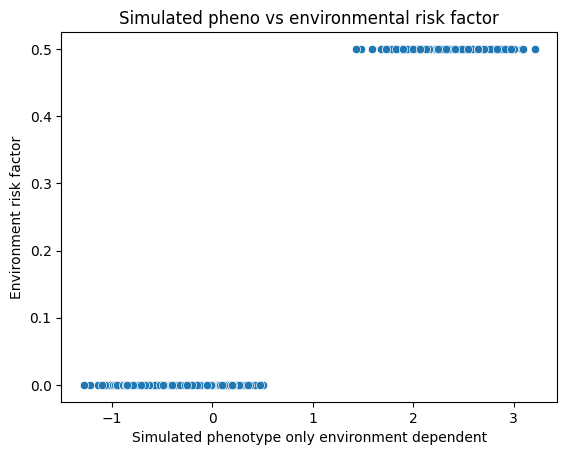

In [55]:
sns.scatterplot(x=list(y), y=list(np.array(risk[name_risk])))
plt.xlabel('Simulated phenotype only environment dependent')
plt.ylabel('Environment risk factor')
plt.title('Simulated pheno vs environmental risk factor')
plt.show()

# Comparaisons

In [56]:
# No correction
df_no_corr = manhattan_linear(complete, risk[['pheno']])

Global phenotype
No Covs!


In [57]:
# X and Y axis as covaraites
pops = populations[['x','y']]
df_pops = manhattan_linear(complete, y , pops)

Pheno is not None and not a dataframe
Covs


In [88]:
true_twopqs

,CG34_AF_0.32671875,CG47_AF_0.27078125,CG81_AF_0.33859375,CG97_AF_0.33953125,CG117_AF_0.365,CG138_AF_0.3371875,CG140_AF_0.38703125,CG143_AF_0.4365625,CG167_AF_0.36015625,CG181_AF_0.3053125,...,VRG1931_AF_0.03625,VRG1939_AF_0.039375,VRG1945_AF_0.02859375,VRG1973_AF_0.02484375,VRG1980_AF_0.0459375,VRG1981_AF_0.02609375,VRG1986_AF_0.03125,VRG1989_AF_0.03859375,VRG1992_AF_0.0453125,VRG1999_AF_0.03125
0,0.28,0.04,0.04,0.08,0.06,0.18,0.02,0.06,0.36,0.08,...,0.02,0.04,0.04,0.08,0.00,0.06,0.04,0.06,0.06,0.02
1,0.28,0.04,0.04,0.08,0.06,0.18,0.02,0.06,0.36,0.08,...,0.02,0.04,0.04,0.08,0.00,0.06,0.04,0.06,0.06,0.02
2,0.28,0.04,0.04,0.08,0.06,0.18,0.02,0.06,0.36,0.08,...,0.02,0.04,0.04,0.08,0.00,0.06,0.04,0.06,0.06,0.02
3,0.28,0.04,0.04,0.08,0.06,0.18,0.02,0.06,0.36,0.08,...,0.02,0.04,0.04,0.08,0.00,0.06,0.04,0.06,0.06,0.02
4,0.28,0.04,0.04,0.08,0.06,0.18,0.02,0.06,0.36,0.08,...,0.02,0.04,0.04,0.08,0.00,0.06,0.04,0.06,0.06,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,0.52,0.16,0.30,0.22,0.24,0.30,0.04,0.30,0.10,0.08,...,0.04,0.04,0.00,0.04,0.02,0.00,0.02,0.00,0.02,0.00
3196,0.52,0.16,0.30,0.22,0.24,0.30,0.04,0.30,0.10,0.08,...,0.04,0.04,0.00,0.04,0.02,0.00,0.02,0.00,0.02,0.00
3197,0.52,0.16,0.30,0.22,0.24,0.30,0.04,0.30,0.10,0.08,...,0.04,0.04,0.00,0.04,0.02,0.00,0.02,0.00,0.02,0.00
3198,0.52,0.16,0.30,0.22,0.24,0.30,0.04,0.30,0.10,0.08,...,0.04,0.04,0.00,0.04,0.02,0.00,0.02,0.00,0.02,0.00


In [59]:
# p2 - q2 and 2pq as covariates
covariate_dictionary = {}
for snp in list(complete.columns):
    temp = complete[[snp]].copy()
    temp[f"{snp}_cov_p_q"] = true_p2s[snp] - true_q2s[snp]
    temp[f"{snp}_cov_2pq"] = true_twopqs[snp]
    temp = temp.drop(columns=[snp])
    covariate_dictionary[snp] = temp
df_p_q_2pq_covs_via_true_pops = manhattan_linear(complete, y, covariate_dictionary)

Pheno is not None and not a dataframe
Dictionary Match!


In [60]:
# Dummies per population
onehotpops = pd.get_dummies(populations[['populations']], columns=['populations']).astype(int)
df_pops_onehot = manhattan_linear(complete, y , onehotpops)

Pheno is not None and not a dataframe
Covs


In [61]:
# Streamline abyss

In [62]:
def abyss(geno_in, geno_out, bottleneck_nr, epoch, patience):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(geno_in, geno_out, test_size=0.2, random_state=42)
    
    # Regularization parameter
    l2_regularizer = 0.001
    
    # Original autoencoder model with L2 regularization
    autoencoder = tf.keras.Sequential([
        tf.keras.layers.Dense(200, activation='elu', input_shape=(geno_in.shape[1],), kernel_regularizer=regularizers.l2(l2_regularizer)),  # First hidden layer with L2 regularization
        #layers.BatchNormalization(),
        #tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(bottleneck_nr, activation='elu', name='bottleneck', kernel_regularizer=regularizers.l2(l2_regularizer)),  # Bottleneck layer with L2 regularization
        layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(200, activation='elu', kernel_regularizer=regularizers.l2(l2_regularizer)),  # Second hidden layer with L2 regularization
        #layers.BatchNormalization(),
        #tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(geno_out.shape[1], activation='linear', kernel_regularizer=regularizers.l2(l2_regularizer))  # Output layer
    ])
    
    # Compile the original model with L2 regularization
    autoencoder.compile(optimizer='adam',
                        loss='mean_squared_error',
                        metrics=['mean_absolute_error'])
    
    # Define Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    # Fit the original model with Early Stopping
    history = autoencoder.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Extract the bottleneck layer after fitting the model
    bottleneck_model = tf.keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('bottleneck').output)
    
    return autoencoder, bottleneck_model, history

In [63]:
# visualise first
bottleneck_nr = 2
epoch = 200
patience = 10
dim_labels = [f"dim{i}" for i in range(1, bottleneck_nr + 1)]

In [64]:
autoencoder, bottleneck_model, history = abyss(complete, complete, bottleneck_nr, epoch, patience)

In [65]:
bottle = pd.DataFrame(data=bottleneck_model(complete), columns = dim_labels)

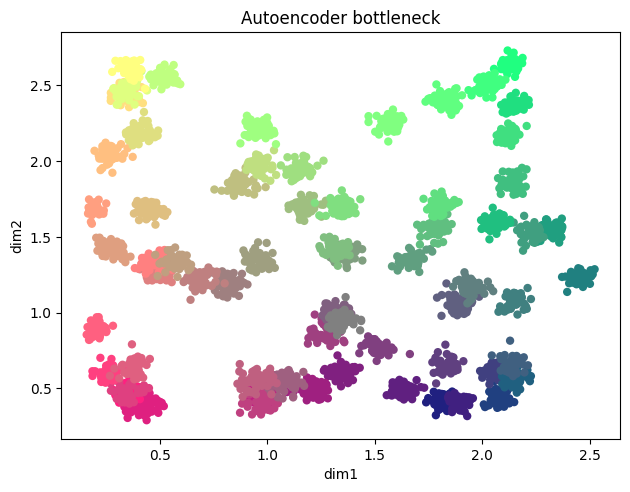

In [66]:
colors = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]
sns.scatterplot(x='dim1', y='dim2', data=bottle, color=colors, linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Autoencoder bottleneck")

# Show the plots
plt.show()

In [67]:
"""
# to check the mafs
mafs = []
for snp_id in list(complete.columns):
    try:
        num_maj = complete[[snp_id]].value_counts()[1.0]
    except Exception as e:
        print(e)
        num_maj = 0
    try:
        num_het = complete[[snp_id]].value_counts()[0.0]
    except Exception as e:
        num_het = 0
    try:
        num_min = complete[[snp_id]].value_counts()[-1.0]
    except Exception as e:
        num_min = 0
    total_humans = num_maj + num_het + num_min
    maf = (num_min*2 + num_het)/(total_humans*2)
    mafs.append(maf)


autoencoder, bottleneck_model, history = abyss((complete +1)/2, (complete +1)/2, bottleneck_nr, epoch, patience)
p = autoencoder(tf.convert_to_tensor((complete +1)/2, dtype=tf.float32))
ps = pd.DataFrame(data=p, columns = complete.columns)

autoencoder, bottleneck_model, history = abyss((complete -1)/-2, (complete -1)/-2, bottleneck_nr, epoch, patience)
q = autoencoder(tf.convert_to_tensor((complete -1)/-2, dtype=tf.float32))
qs = pd.DataFrame(data=q, columns = complete.columns)

compare = pd.DataFrame()

compare['counted_mafs'] = mafs

compare['autoencoder_ps'] = list(1-ps.mean())
compare['autoencoder_qs'] = list(qs.mean())

sns.scatterplot(x='counted_mafs', y='autoencoder_ps', data=compare, color='blue', linewidth=0)
sns.scatterplot(x='counted_mafs', y='autoencoder_qs', data=compare, color='red', linewidth=0)
"""

"\n# to check the mafs\nmafs = []\nfor snp_id in list(complete.columns):\n    try:\n        num_maj = complete[[snp_id]].value_counts()[1.0]\n    except Exception as e:\n        print(e)\n        num_maj = 0\n    try:\n        num_het = complete[[snp_id]].value_counts()[0.0]\n    except Exception as e:\n        num_het = 0\n    try:\n        num_min = complete[[snp_id]].value_counts()[-1.0]\n    except Exception as e:\n        num_min = 0\n    total_humans = num_maj + num_het + num_min\n    maf = (num_min*2 + num_het)/(total_humans*2)\n    mafs.append(maf)\n\n\nautoencoder, bottleneck_model, history = abyss((complete +1)/2, (complete +1)/2, bottleneck_nr, epoch, patience)\np = autoencoder(tf.convert_to_tensor((complete +1)/2, dtype=tf.float32))\nps = pd.DataFrame(data=p, columns = complete.columns)\n\nautoencoder, bottleneck_model, history = abyss((complete -1)/-2, (complete -1)/-2, bottleneck_nr, epoch, patience)\nq = autoencoder(tf.convert_to_tensor((complete -1)/-2, dtype=tf.float32

In [68]:
"""
# Function to ensure minimum cluster size
def ensure_min_cluster_size(data, labels, min_size):
    unique_labels, counts = np.unique(labels, return_counts=True)
    small_clusters = unique_labels[counts < min_size]
    
    # Reassign points from small clusters to the nearest large cluster
    for cluster in small_clusters:
        indices = np.where(labels == cluster)[0]
        for index in indices:
            # Find nearest large cluster
            nearest_large_cluster = None
            nearest_distance = float('inf')
            for label in unique_labels:
                if label not in small_clusters:
                    distance = np.linalg.norm(data.iloc[index] - kmeans.cluster_centers_[label])
                    if distance < nearest_distance:
                        nearest_distance = distance
                        nearest_large_cluster = label
            labels[index] = nearest_large_cluster
    
    return labels

"""

"\n# Function to ensure minimum cluster size\ndef ensure_min_cluster_size(data, labels, min_size):\n    unique_labels, counts = np.unique(labels, return_counts=True)\n    small_clusters = unique_labels[counts < min_size]\n    \n    # Reassign points from small clusters to the nearest large cluster\n    for cluster in small_clusters:\n        indices = np.where(labels == cluster)[0]\n        for index in indices:\n            # Find nearest large cluster\n            nearest_large_cluster = None\n            nearest_distance = float('inf')\n            for label in unique_labels:\n                if label not in small_clusters:\n                    distance = np.linalg.norm(data.iloc[index] - kmeans.cluster_centers_[label])\n                    if distance < nearest_distance:\n                        nearest_distance = distance\n                        nearest_large_cluster = label\n            labels[index] = nearest_large_cluster\n    \n    return labels\n\n"

In [69]:
"""
from sklearn.cluster import KMeans
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(bottle)

# Step 3: Assign the cluster labels to each data point
labels = kmeans.labels_

# Step 4: Ensure minimum cluster size
min_size = c  # Set your desired minimum cluster size
labels = ensure_min_cluster_size(bottle, labels, min_size)
"""

'\nfrom sklearn.cluster import KMeans\nn_clusters = 8\nkmeans = KMeans(n_clusters=n_clusters, random_state=42)\nkmeans.fit(bottle)\n\n# Step 3: Assign the cluster labels to each data point\nlabels = kmeans.labels_\n\n# Step 4: Ensure minimum cluster size\nmin_size = c  # Set your desired minimum cluster size\nlabels = ensure_min_cluster_size(bottle, labels, min_size)\n'

In [70]:
"""
complete['populations'] = labels
unique_pops = list(complete['populations'].unique())
bottleneck_nr = 256
dim_labels = [f"dim{i}" for i in range(1, bottleneck_nr + 1)]
epoch = 50
patience = 15
ps = []
qs = []

for pop in unique_pops:
    temp_geno = complete[complete['populations'] == pop]
    temp_geno.drop("populations", axis=1, inplace=True)
    
    autoencoder, bottleneck_model, history = abyss((temp_geno +1)/2, (temp_geno +1)/2, bottleneck_nr, epoch, patience)
    p = autoencoder(tf.convert_to_tensor((temp_geno +1)/2, dtype=tf.float32))
    p = pd.DataFrame(data=p, columns = temp_geno.columns)
    p.index = temp_geno.index
    ps.append(p)

    autoencoder, bottleneck_model, history = abyss((temp_geno -1)/-2, (temp_geno -1)/-2, bottleneck_nr, epoch, patience)
    q = autoencoder(tf.convert_to_tensor((temp_geno -1)/-2, dtype=tf.float32))
    q = pd.DataFrame(data=q, columns = temp_geno.columns)
    q.index = temp_geno.index
    qs.append(q)
ps = pd.concat(ps)
qs = pd.concat(qs)

ps.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/estimated_ps_via_estimated_pop.pkl")
qs.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/estimated_qs_via_estimated_pop.pkl")

complete.drop("populations", axis=1, inplace=True)
"""

'\ncomplete[\'populations\'] = labels\nunique_pops = list(complete[\'populations\'].unique())\nbottleneck_nr = 256\ndim_labels = [f"dim{i}" for i in range(1, bottleneck_nr + 1)]\nepoch = 50\npatience = 15\nps = []\nqs = []\n\nfor pop in unique_pops:\n    temp_geno = complete[complete[\'populations\'] == pop]\n    temp_geno.drop("populations", axis=1, inplace=True)\n    \n    autoencoder, bottleneck_model, history = abyss((temp_geno +1)/2, (temp_geno +1)/2, bottleneck_nr, epoch, patience)\n    p = autoencoder(tf.convert_to_tensor((temp_geno +1)/2, dtype=tf.float32))\n    p = pd.DataFrame(data=p, columns = temp_geno.columns)\n    p.index = temp_geno.index\n    ps.append(p)\n\n    autoencoder, bottleneck_model, history = abyss((temp_geno -1)/-2, (temp_geno -1)/-2, bottleneck_nr, epoch, patience)\n    q = autoencoder(tf.convert_to_tensor((temp_geno -1)/-2, dtype=tf.float32))\n    q = pd.DataFrame(data=q, columns = temp_geno.columns)\n    q.index = temp_geno.index\n    qs.append(q)\nps = pd

In [71]:
"""
ps = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/estimated_ps_via_estimated_pop.pkl")
qs = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/estimated_qs_via_estimated_pop.pkl")
"""

'\nps = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/estimated_ps_via_estimated_pop.pkl")\nqs = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/estimated_qs_via_estimated_pop.pkl")\n'

In [72]:
"""
covariate_dictionary = {}
for snp in list(complete.columns):
    temp = complete[[snp]].copy()
    temp[f"{snp}_cov_p2"] = ps[snp]**2
    temp[f"{snp}_cov_q2"] = qs[snp]**2
    temp[f"{snp}_cov_2pq"] = 2*ps[snp]*qs[snp]
    temp = temp.drop(columns=[snp])
    covariate_dictionary[snp] = temp
"""

'\ncovariate_dictionary = {}\nfor snp in list(complete.columns):\n    temp = complete[[snp]].copy()\n    temp[f"{snp}_cov_p2"] = ps[snp]**2\n    temp[f"{snp}_cov_q2"] = qs[snp]**2\n    temp[f"{snp}_cov_2pq"] = 2*ps[snp]*qs[snp]\n    temp = temp.drop(columns=[snp])\n    covariate_dictionary[snp] = temp\n'

In [73]:
"""
df_abyss_p_q_covs_via_esti_pop = manhattan_linear(complete, y, covariate_dictionary)
"""

'\ndf_abyss_p_q_covs_via_esti_pop = manhattan_linear(complete, y, covariate_dictionary)\n'

In [74]:
# PCA
nr_common_PCs = 24
pc_columns = ['PC{}'.format(i) for i in range(1, nr_common_PCs+1)]
PC_common= pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs/common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")
df_PCs = manhattan_linear(complete, y , PC_common[pc_columns])

Pheno is not None and not a dataframe
Covs


In [75]:
"""
# Create db_minor
db_minor = complete.copy()
db_minor = db_minor.applymap(lambda x: 1 if x == -1.0 else 0)

# Create db_het
db_het = complete.copy()
db_het = db_het.applymap(lambda x: 1 if x == 0.0 else 0)

# Create db_major
db_major = complete.copy()
db_major = db_major.applymap(lambda x: 1 if x == 1.0 else 0)

db_minor.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_minor.pkl")
db_het.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_het.pkl")
db_major.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_major.pkl")
"""

'\n# Create db_minor\ndb_minor = complete.copy()\ndb_minor = db_minor.applymap(lambda x: 1 if x == -1.0 else 0)\n\n# Create db_het\ndb_het = complete.copy()\ndb_het = db_het.applymap(lambda x: 1 if x == 0.0 else 0)\n\n# Create db_major\ndb_major = complete.copy()\ndb_major = db_major.applymap(lambda x: 1 if x == 1.0 else 0)\n\ndb_minor.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_minor.pkl")\ndb_het.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_het.pkl")\ndb_major.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_major.pkl")\n'

In [76]:
db_minor = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_minor.pkl")
db_het = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_het.pkl")
db_major = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_major.pkl")

In [77]:
def abyss(geno_in, geno_out, bottleneck_nr, epoch, patience):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(geno_in, geno_out, test_size=0.2, random_state=42)
    
    # Regularization parameter
    l2_regularizer = 0.001
    
    # Original autoencoder model with L2 regularization
    autoencoder = tf.keras.Sequential([
        tf.keras.layers.Dense(200, activation='elu', input_shape=(geno_in.shape[1],), kernel_regularizer=regularizers.l2(l2_regularizer)),  # First hidden layer with L2 regularization
        #layers.BatchNormalization(),
        #tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(bottleneck_nr, activation='elu', name='bottleneck', kernel_regularizer=regularizers.l2(l2_regularizer)),  # Bottleneck layer with L2 regularization
        layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(200, activation='elu', kernel_regularizer=regularizers.l2(l2_regularizer)),  # Second hidden layer with L2 regularization
        #layers.BatchNormalization(),
        #tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(geno_out.shape[1], activation='linear', kernel_regularizer=regularizers.l2(l2_regularizer))  # Output layer
    ])
    
    # Compile the original model with L2 regularization
    autoencoder.compile(optimizer='adam',
                        loss='mean_squared_error',
                        metrics=['mean_absolute_error'])
    
    # Define Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    # Fit the original model with Early Stopping
    history = autoencoder.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Extract the bottleneck layer after fitting the model
    bottleneck_model = tf.keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('bottleneck').output)
    
    return autoencoder, bottleneck_model, history

In [78]:
"""
bottleneck_nr = 64
epoch = 200
patience = 10
dim_labels = [f"dim{i}" for i in range(1, bottleneck_nr + 1)]
autoencoder, bottleneck_model, history = abyss(complete, complete, bottleneck_nr, epoch, patience)
bottle = pd.DataFrame(data=bottleneck_model(complete), columns = dim_labels)
"""

'\nbottleneck_nr = 64\nepoch = 200\npatience = 10\ndim_labels = [f"dim{i}" for i in range(1, bottleneck_nr + 1)]\nautoencoder, bottleneck_model, history = abyss(complete, complete, bottleneck_nr, epoch, patience)\nbottle = pd.DataFrame(data=bottleneck_model(complete), columns = dim_labels)\n'

In [79]:
# Function to ensure minimum cluster size
def ensure_min_cluster_size(data, labels, min_size):
    unique_labels, counts = np.unique(labels, return_counts=True)
    small_clusters = unique_labels[counts < min_size]
    
    # Reassign points from small clusters to the nearest large cluster
    for cluster in small_clusters:
        indices = np.where(labels == cluster)[0]
        for index in indices:
            # Find nearest large cluster
            nearest_large_cluster = None
            nearest_distance = float('inf')
            for label in unique_labels:
                if label not in small_clusters:
                    distance = np.linalg.norm(data.iloc[index] - kmeans.cluster_centers_[label])
                    if distance < nearest_distance:
                        nearest_distance = distance
                        nearest_large_cluster = label
            labels[index] = nearest_large_cluster
    
    return labels

In [80]:
"""
from sklearn.cluster import KMeans
n_clusters = 120
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(bottle)

# Step 3: Assign the cluster labels to each data point
labels = kmeans.labels_

# Step 4: Ensure minimum cluster size
min_size = 10  # Set your desired minimum cluster size
labels = ensure_min_cluster_size(bottle, labels, min_size)
"""

'\nfrom sklearn.cluster import KMeans\nn_clusters = 120\nkmeans = KMeans(n_clusters=n_clusters, random_state=42)\nkmeans.fit(bottle)\n\n# Step 3: Assign the cluster labels to each data point\nlabels = kmeans.labels_\n\n# Step 4: Ensure minimum cluster size\nmin_size = 10  # Set your desired minimum cluster size\nlabels = ensure_min_cluster_size(bottle, labels, min_size)\n'

In [81]:
"""
bottle['cluster'] = labels
unique_pops = list(bottle['cluster'].unique())

db_major['populations'] = bottle['cluster']
db_het['populations'] = bottle['cluster']
db_minor['populations'] = bottle['cluster']

true_p2s['populations'] = bottle['cluster']
true_twopqs['populations'] = bottle['cluster']
true_q2s['populations'] = bottle['cluster']

bottleneck_nr = 1
dim_labels = [f"dim{i}" for i in range(1, bottleneck_nr + 1)]
epoch = 500
patience = 15
p2s = []
for pop in unique_pops:
    temp_major = db_major[db_major['populations'] == pop]
    temp_major.drop("populations", axis=1, inplace=True)
    temp_p2s = true_p2s[true_p2s['populations'] == pop]
    temp_p2s.drop("populations", axis=1, inplace=True)
    autoencoder, bottleneck_model, history = abyss(temp_major, temp_major, bottleneck_nr, epoch, patience)
    p2 = autoencoder(tf.convert_to_tensor(temp_major, dtype=tf.float32))
    p2 = pd.DataFrame(data=p2, columns = complete.columns)
    p2.index = temp_major.index
    p2_bottle = pd.DataFrame(data=bottleneck_model(temp_major), columns = dim_labels)
    p2_bottle.index = temp_major.index
    p2s.append(p2)
print("done with p2")

twopqs = []
for pop in unique_pops:
    temp_het = db_het[db_het['populations'] == pop]
    temp_het.drop("populations", axis=1, inplace=True)
    temp_2pqs = true_twopqs[true_twopqs['populations'] == pop]
    temp_2pqs.drop("populations", axis=1, inplace=True)
    autoencoder, bottleneck_model, history = abyss(temp_het, temp_het, bottleneck_nr, epoch, patience)
    twopq = autoencoder(tf.convert_to_tensor(temp_het, dtype=tf.float32))
    twopq = pd.DataFrame(data=twopq, columns = complete.columns)
    twopq.index = temp_het.index
    twopq_bottle = pd.DataFrame(data=bottleneck_model(temp_het), columns = dim_labels)
    twopq_bottle.index = temp_het.index
    twopqs.append(twopq)
print("done with 2pq")

q2s = []
for pop in unique_pops:
    temp_minor = db_minor[db_minor['populations'] == pop]
    temp_minor.drop("populations", axis=1, inplace=True)
    temp_q2s = true_q2s[true_q2s['populations'] == pop]
    temp_q2s.drop("populations", axis=1, inplace=True)
    autoencoder, bottleneck_model, history = abyss(temp_minor, temp_minor, bottleneck_nr, epoch, patience)
    q2 = autoencoder(tf.convert_to_tensor(temp_minor, dtype=tf.float32))
    q2 = pd.DataFrame(data=q2, columns = complete.columns)
    q2.index = temp_minor.index
    q2_bottle = pd.DataFrame(data=bottleneck_model(temp_minor), columns = dim_labels)
    q2_bottle.index = temp_minor.index
    q2s.append(q2)

print("done with q2")


p2 = pd.concat(p2s)
twopq = pd.concat(twopqs)
q2 = pd.concat(q2s)

p2.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/estimated_truep2_via_estimated_pop.pkl")
twopq.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/estimated_true2pq_via_estimated_pop.pkl")
q2.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/estimated_trueq2_via_estimated_pop.pkl")
"""

'\nbottle[\'cluster\'] = labels\nunique_pops = list(bottle[\'cluster\'].unique())\n\ndb_major[\'populations\'] = bottle[\'cluster\']\ndb_het[\'populations\'] = bottle[\'cluster\']\ndb_minor[\'populations\'] = bottle[\'cluster\']\n\ntrue_p2s[\'populations\'] = bottle[\'cluster\']\ntrue_twopqs[\'populations\'] = bottle[\'cluster\']\ntrue_q2s[\'populations\'] = bottle[\'cluster\']\n\nbottleneck_nr = 1\ndim_labels = [f"dim{i}" for i in range(1, bottleneck_nr + 1)]\nepoch = 500\npatience = 15\np2s = []\nfor pop in unique_pops:\n    temp_major = db_major[db_major[\'populations\'] == pop]\n    temp_major.drop("populations", axis=1, inplace=True)\n    temp_p2s = true_p2s[true_p2s[\'populations\'] == pop]\n    temp_p2s.drop("populations", axis=1, inplace=True)\n    autoencoder, bottleneck_model, history = abyss(temp_major, temp_major, bottleneck_nr, epoch, patience)\n    p2 = autoencoder(tf.convert_to_tensor(temp_major, dtype=tf.float32))\n    p2 = pd.DataFrame(data=p2, columns = complete.colum

In [82]:
p2 = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/estimated_truep2_via_estimated_pop.pkl")
twopq = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/estimated_true2pq_via_estimated_pop.pkl")
q2 = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/estimated_trueq2_via_estimated_pop.pkl")

In [83]:
covariate_dictionary = {}
for snp in list(complete.columns):
    temp = complete[[snp]].copy()
    temp[f"{snp}_cov_p2"] = p2[snp]
    temp[f"{snp}_cov_q2"] = q2[snp]
    temp[f"{snp}_cov_2pq"] = twopq[snp]
    temp = temp.drop(columns=[snp])
    covariate_dictionary[snp] = temp

In [84]:
df_abyss_p_q_2pq_covs_via_esti_pop = manhattan_linear(complete, y, covariate_dictionary)

Pheno is not None and not a dataframe
Dictionary Match!


In [85]:
# Create QQ plot
df_bests = pd.DataFrame()
df_bests["-logP_no_corr"] = np.sort(df_no_corr['-logPs'])
df_bests["-logP_true_pop"] = np.sort(df_pops['-logPs'])
df_bests["-logP_true_pop_onehot"] = np.sort(df_pops_onehot['-logPs'])
#df_bests["-logP_abyss_via_esti_pops"] = np.sort(df_abyss_p_q_covs_via_esti_pop['-logPs'])
df_bests["-logP_abyss_via_true_pops"] = np.sort(df_p_q_2pq_covs_via_true_pops['-logPs'])
df_bests["-logP_abyss_pq2pq_via_esti_pops"] = np.sort(df_abyss_p_q_2pq_covs_via_esti_pop['-logPs'])


df_bests["-logP_PCs"] = np.sort(df_PCs['-logPs'])

In [86]:
# Find the maximum value in the DataFrame excluding inf and NaN
max_value = df_bests.replace([np.inf, -np.inf], np.nan).max().max()

# Replace inf values with the maximum value found
df_bests.replace([np.inf, -np.inf], max_value, inplace=True)

# Replace NaN values with the maximum value found
df_bests.fillna(max_value, inplace=True)
n = len(df_bests)
expected_quantiles = np.arange(1, n + 1) / n
expected_logP = np.sort(-np.log10(expected_quantiles))
df_bests['expected_logP'] = expected_logP

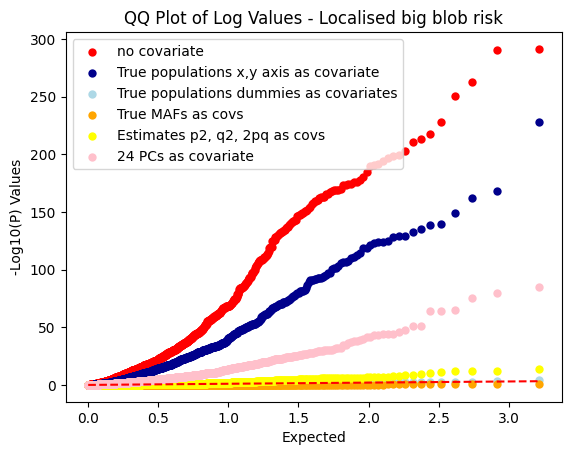

In [87]:
sns.scatterplot(x='expected_logP', y='-logP_no_corr', data=df_bests, color='red', label='no covariate', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_true_pop', data=df_bests, color='darkblue', label='True populations x,y axis as covariate', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_true_pop_onehot', data=df_bests, color='lightblue', label='True populations dummies as covariates', linewidth=0)

#sns.scatterplot(x='expected_logP', y='-logP_abyss_via_esti_pops', data=df_bests, color='purple', label='Estimated MAFs as covs', linewidth=0)
sns.scatterplot(x='expected_logP', y='-logP_abyss_via_true_pops', data=df_bests, color='orange', label='True MAFs as covs', linewidth=0)
sns.scatterplot(x='expected_logP', y='-logP_abyss_pq2pq_via_esti_pops', data=df_bests, color='yellow', label='Estimates p2, q2, 2pq as covs', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_PCs', data=df_bests, color='pink', label=f"{nr_common_PCs} PCs as covariate", linewidth=0)

# Plot diagonal reference line
plt.plot([min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         [min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         color='red', linestyle='--')

# Set plot labels and title
plt.xlabel('Expected')
plt.ylabel('-Log10(P) Values')
plt.title(f"QQ Plot of Log Values - {naming_dict[name_risk]}")

# Show legend
plt.legend()
#plt.savefig(f"data/plots/qq_pheno_{name_risk}_iter_{iterations}_G{G}_L{L}_c{c}_k{k}_M{M}.png", dpi=100)
# Show plot
plt.show()